In [ ]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

# -----------------------------
# Ragged -> dense matrix (padded)
# -----------------------------
def to_matrix(sensor_energy_col, max_layers=None, dtype=np.float32):
    """
    Convert a column of variable-length per-layer energies into a dense [N, L] array.
    Pads with zeros up to L = max_layers (or max observed length).
    """
    # Fast pass: pre-coerce to arrays once
    arrs = [
        np.asarray(v if v is not None else [], dtype=dtype).ravel()
        for v in sensor_energy_col
    ]
    L = int(max_layers) if max_layers is not None else (
        max((a.size for a in arrs), default=0)
    )
    N = len(arrs)
    M = np.zeros((N, L), dtype=dtype)
    # Tight loop with slice copy (fast in NumPy; avoids Python math inside)
    for i, a in enumerate(arrs):
        k = a.size if a.size <= L else L
        if k:
            M[i, :k] = a[:k]
    return M

# -----------------------------
# Builder: tensors, scalers, loaders
# -----------------------------
def build_dataset_loaders(
    df_train,
    *,
    max_layers=None,          # set if you want a fixed L; else uses max in df
    val_split=0.10,
    batch_size=512,
    seed=42,
    device=None               # "cuda", "mps", or "cpu" (auto-detect default)
):
    """
    Produces:
      - Xt, yt (standardized inputs on CPU torch tensors)
      - tr_loader, va_loader
      - input_dim
      - scalers dict: {"x_mean":..., "x_std":...} as numpy float32
    """
    # --- features/targets ---
    X = to_matrix(df_train["sensor_energy"], max_layers=max_layers)     # [N, L]
    y = df_train["true_energy"].to_numpy(np.float32).reshape(-1, 1)     # [N, 1]
    assert X.shape[1] > 0, "Zero feature columns — check 'sensor_energy' content."

    # --- to torch ---
    X_t = torch.from_numpy(X)          # float32 already
    y_t = torch.from_numpy(y)          # float32 already

    # --- standardize with torch for speed/stability ---
    # mean/std over the batch dimension (dim=0), keepdims for broadcast
    x_mean_t = X_t.mean(dim=0, keepdim=True)
    x_std_t  = X_t.std(dim=0, unbiased=False, keepdim=True).clamp_min(1e-6)
    Xz_t     = (X_t - x_mean_t) / x_std_t

    # Keep scalers as numpy so you can reuse them later for eval/inference
    scalers = {
        "x_mean": x_mean_t.squeeze(0).cpu().numpy().astype(np.float32),
        "x_std":  x_std_t.squeeze(0).cpu().numpy().astype(np.float32),
    }

    # --- dataset + split ---
    ds = TensorDataset(Xz_t, y_t)
    n_val = int(val_split * len(ds))
    n_tr  = len(ds) - n_val
    g = torch.Generator().manual_seed(int(seed))
    tr_ds, va_ds = random_split(ds, [n_tr, n_val], generator=g)

    # --- loaders (set workers/pinning smartly) ---
    use_cuda = torch.cuda.is_available()
    use_mps  = getattr(torch.backends, "mps", None) and torch.backends.mps.is_available()
    if device is None:
        device = "cuda" if use_cuda else ("mps" if use_mps else "cpu")

    # pin_memory helps only when moving to CUDA; harmless otherwise
    pin = bool(device == "cuda")
    # a couple of workers often speeds up collation even on CPU
    num_workers = 2 if len(ds) >= 2048 else 0

    tr_loader = DataLoader(
        tr_ds,
        batch_size=batch_size,
        shuffle=True,
        drop_last=False,
        pin_memory=pin,
        num_workers=num_workers,
        persistent_workers=(num_workers > 0),
    )
    va_loader = DataLoader(
        va_ds,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        pin_memory=pin,
        num_workers=num_workers,
        persistent_workers=(num_workers > 0),
    )

    input_dim = X.shape[1]
    return Xz_t, y_t, tr_loader, va_loader, input_dim, scalers

# =========================
# Usage
# =========================
# Xz, y, tr_loader, va_loader, input_dim, scalers = build_dataset_loaders(
#     df_train,
#     max_layers=None,        # or a fixed number like 156
#     val_split=0.10,
#     batch_size=512,
#     seed=42
# )
# print("input_dim:", input_dim)


X shape: (10000, 156)
input_dim: 156


In [19]:
import torch
from torch import nn
import wandb
from copy import deepcopy

# ----- knobs you can tweak quickly -----
EPOCHS        = 500
PATIENCE      = 30      # early-stopping patience (epochs without improvement)
LR_INIT       = 3e-4
LR_MIN        = 1e-5    # floor for cosine schedule
WEIGHT_DECAY  = 1e-4
BATCH_SIZE    = 32

# --- login + initialize wandb run ---
wandb.login()
wandb.init(
    project="calo-dnn",
    name="triple_ecal_then_fe_scint_hcal_2m_v4_2_cosineES_128-64-32",
    config={
        "architecture": "128-64-32-1 Softplus",
        "activation": "SELU",
        "optimizer": "AdamW",
        "lr": LR_INIT,
        "lr_min": LR_MIN,
        "weight_decay": WEIGHT_DECAY,
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "loss": "((E_true - E_pred)^2) / E_true",
        "early_stopping_patience": PATIENCE,
        "scheduler": "CosineAnnealingLR"
    },
)

# --- define model, optimizer, scheduler, and loss ---
# expects: input_dim, tr_loader, va_loader already defined in your notebook
model = nn.Sequential(
    nn.Linear(input_dim, 128), nn.SELU(),
    nn.Linear(128, 64),        nn.SELU(),
    nn.Linear(64, 32),         nn.SELU(),
    nn.Linear(32, 1),
    nn.Softplus()  # keep outputs positive
)
opt = torch.optim.AdamW(model.parameters(), lr=LR_INIT, weight_decay=WEIGHT_DECAY)

# Cosine schedule over the full training horizon
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer=opt, T_max=EPOCHS, eta_min=LR_MIN
)

def relE_loss(pred, y):                  # ((E_true - E_pred)^2) / E_true
    return torch.mean(((y - pred)**2) / y)

# --- early stopping setup ---
best_val = float("inf")
best_state = None
best_epoch = 0
wait = 0

# --- training loop with cosine LR + early stopping ---
for epoch in range(1, EPOCHS + 1):
    # train
    model.train()
    total_loss = 0.0
    for xb, yb in tr_loader:
        opt.zero_grad(set_to_none=True)
        pred = model(xb)
        loss = relE_loss(pred, yb)
        loss.backward()
        opt.step()
        total_loss += loss.item() * xb.size(0)
    train_loss = total_loss / len(tr_loader.dataset)

    # validate
    model.eval()
    val_total = 0.0
    with torch.no_grad():
        for xb, yb in va_loader:
            val_total += relE_loss(model(xb), yb).item() * xb.size(0)
    val_loss = val_total / len(va_loader.dataset)

    # scheduler step *after* logging current epoch loss
    scheduler.step()
    cur_lr = scheduler.get_last_lr()[0]

    # log
    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "lr": cur_lr
    })

    # early stopping check
    if val_loss < best_val - 1e-6:
        best_val = val_loss
        best_state = deepcopy(model.state_dict())
        best_epoch = epoch
        wait = 0
    else:
        wait += 1
        if wait >= PATIENCE:
            print(f"⏹️ Early stopping at epoch {epoch} (best @ {best_epoch}, val={best_val:.4f})")
            break

# restore best weights
if best_state is not None:
    model.load_state_dict(best_state)

wandb.summary["best_val_loss"] = float(best_val)
wandb.summary["best_epoch"] = int(best_epoch)
wandb.finish()
print(f"✅ Training finished. Best epoch: {best_epoch}  best val loss: {best_val:.6f}")


⏹️ Early stopping at epoch 267 (best @ 237, val=0.1450)


epoch,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
lr,██████████▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▄▃▃▃▂▂▂▂▁▁
train_loss,█▅▅▅▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▆▅▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,237
best_val_loss,0.14496
epoch,267
lr,0.00014
train_loss,0.1863
val_loss,0.14695


✅ Training finished. Best epoch: 237  best val loss: 0.144962


DNN loss=1.324  |  BASE loss=41.270  |  MAE=7.025 GeV  |  RMSE=9.489 GeV


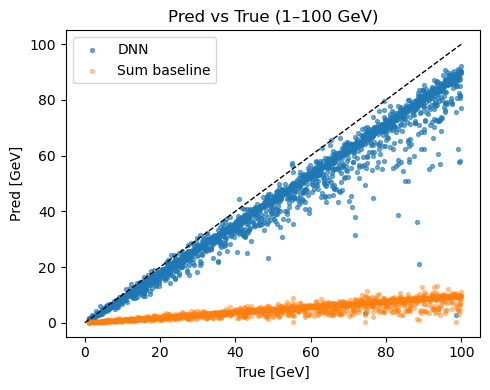

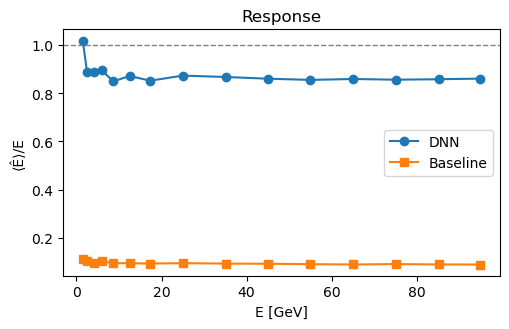

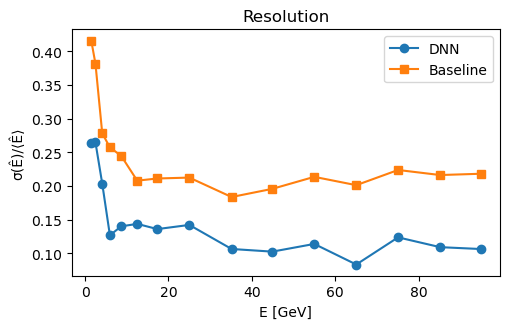

In [21]:
import re, numpy as np, pandas as pd, torch, matplotlib.pyplot as plt

# --- helpers ---
def ensure_sensor_energy(df: pd.DataFrame) -> pd.DataFrame:
    if "sensor_energy" in df.columns and df["sensor_energy"].apply(
        lambda x: isinstance(x,(list,tuple,np.ndarray)) and len(x)>0
    ).all():
        return df
    layer_cols = sorted([c for c in df.columns if re.fullmatch(r"layer_\d{3}_MeV", c)],
                        key=lambda s: int(s.split("_")[1]))
    df = df.copy()
    df["sensor_energy"] = df[layer_cols].values.tolist()
    return df

def to_matrix(sensor_energy_col, max_layers):
    rows = [np.asarray(v, np.float32).ravel() for v in sensor_energy_col]
    M = np.zeros((len(rows), max_layers), np.float32)
    for i,a in enumerate(rows):
        L = min(max_layers, a.size)
        if L: M[i,:L] = a[:L]
    return M

def baseline_sum_GeV(df):
    layer_cols = [c for c in df.columns if c.startswith("layer_") and c.endswith("_MeV")]
    if layer_cols:
        return df[layer_cols].to_numpy(np.float64).sum(axis=1) / 1000.0
    return np.array([np.sum(x)/1000.0 for x in df["sensor_energy"]], dtype=np.float64)

def brr(y_true, y_pred, edges):
    centers, resp, reso = [], [], []
    for lo, hi in zip(edges[:-1], edges[1:]):
        m = (y_true >= lo) & (y_true < hi)
        if not np.any(m): continue
        yt, yp = y_true[m], y_pred[m]
        Ebar, mu, sig = float(np.mean(yt)), float(np.mean(yp)), float(np.std(yp, ddof=1))
        centers.append(Ebar)
        resp.append(mu/Ebar if Ebar>0 else np.nan)
        reso.append(sig/mu if mu>0 else np.nan)
    return np.array(centers), np.array(resp), np.array(reso)

# --- load eval (1–100 GeV) ---
df_ev = pd.concat([
    pd.read_pickle("eval_gamma_1to100.pkl"),
    pd.read_pickle("eval_pion_1to100.pkl")
], ignore_index=True)
df_ev = ensure_sensor_energy(df_ev)
df_ev = df_ev[(df_ev["true_energy"]>=1) & (df_ev["true_energy"]<=100)].reset_index(drop=True)

# --- features -> normalize with your TRAIN scalers ---
M = to_matrix(df_ev["sensor_energy"], max_layers=int(input_dim))
X = (np.nan_to_num(M) - x_mean) / (x_std + 1e-12)

# --- predict ---
with torch.no_grad():
    y_pred = model(torch.tensor(X, dtype=torch.float32)).numpy().ravel()
y_true = df_ev["true_energy"].to_numpy(float)
y_base = baseline_sum_GeV(df_ev)

# --- metrics (same loss as training, no epsilon) ---
dnn_loss  = float(np.mean(((y_true - y_pred)**2) / y_true))
base_loss = float(np.mean(((y_true - y_base)**2) / y_true))
mae  = float(np.mean(np.abs(y_pred - y_true)))
rmse = float(np.sqrt(np.mean((y_pred - y_true)**2)))
print(f"DNN loss={dnn_loss:.3f}  |  BASE loss={base_loss:.3f}  |  MAE={mae:.3f} GeV  |  RMSE={rmse:.3f} GeV")

# --- quick plots ---
plt.figure(figsize=(5,4))
plt.scatter(y_true, y_pred, s=8, alpha=0.6, label="DNN")
plt.scatter(y_true, y_base, s=8, alpha=0.4, label="Sum baseline")
mx = max(y_true.max(), y_pred.max(), y_base.max()); plt.plot([0,mx],[0,mx],'k--',lw=1)
plt.xlabel("True [GeV]"); plt.ylabel("Pred [GeV]"); plt.title("Pred vs True (1–100 GeV)")
plt.legend(); plt.tight_layout(); plt.show()

edges = np.array([1,2,3,5,7,10,15,20,30,40,50,60,70,80,90,100], float)
c_d, r_d, s_d = brr(y_true, y_pred, edges)
c_b, r_b, s_b = brr(y_true, y_base, edges)

plt.figure(figsize=(5.2,3.4))
plt.plot(c_d, r_d, marker='o', label="DNN"); plt.plot(c_b, r_b, marker='s', label="Baseline")
plt.axhline(1.0, ls='--', lw=1, color='gray'); plt.xlabel("E [GeV]"); plt.ylabel("⟨Ê⟩/E"); plt.title("Response")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(5.2,3.4))
plt.plot(c_d, s_d, marker='o', label="DNN"); plt.plot(c_b, s_b, marker='s', label="Baseline")
plt.xlabel("E [GeV]"); plt.ylabel("σ(Ê)/⟨Ê⟩"); plt.title("Resolution"); plt.legend(); plt.tight_layout(); plt.show()


df_eval not found in memory; searching for eval files from: /Users/egeeroglu/Desktop/Notebooks
  gamma: /Users/egeeroglu/Desktop/Notebooks/eval_gamma_1to100.pkl
  pion : /Users/egeeroglu/Desktop/Notebooks/eval_pion_1to100.pkl
[info] input_dim = 156


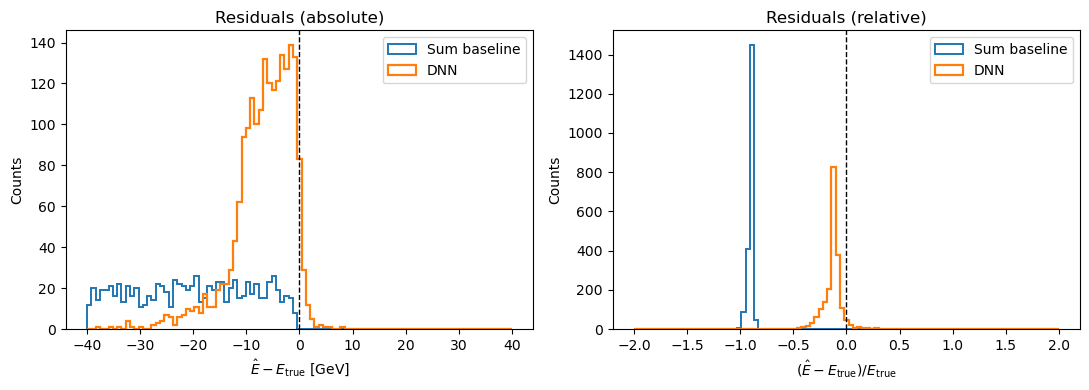

wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


DNN       | mean=-6.894 GeV, σ=6.520 GeV | rel mean=-12.56%, rel σ=11.83%
Baseline  | mean=-45.383 GeV, σ=26.216 GeV | rel mean=-90.74%, rel σ=1.95%


res_mean_base_GeV,▁
res_mean_dnn_GeV,▁
res_sigma_base_GeV,▁
res_sigma_dnn_GeV,▁
res_mean_base_GeV,-45.3835
res_mean_dnn_GeV,-6.89407
res_sigma_base_GeV,26.21645
res_sigma_dnn_GeV,6.52041


In [16]:
# === Residual comparison: DNN vs Baseline (E_pred - E_true) ===
import os, re
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt, torch
from torch import nn

# (optional) wandb is best-effort
try:
    import wandb
    _HAS_WANDB = True
except Exception:
    _HAS_WANDB = False

# ---------------- helpers ----------------
def ensure_sensor_energy(df: pd.DataFrame) -> pd.DataFrame:
    """Ensure df['sensor_energy'] exists; if not, build it from layer_XXX_MeV columns."""
    if "sensor_energy" in df.columns and df["sensor_energy"].apply(
        lambda x: isinstance(x,(list,tuple,np.ndarray)) and len(x)>0
    ).all():
        return df
    layer_cols = sorted(
        [c for c in df.columns if re.fullmatch(r"layer_\d{3}_MeV", c)],
        key=lambda s: int(s.split("_")[1])
    )
    if not layer_cols:
        raise RuntimeError("No layer_XXX_MeV columns to build 'sensor_energy'.")
    out = df.copy()
    out["sensor_energy"] = out[layer_cols].values.tolist()
    return out

def to_matrix(sensor_energy_col, max_layers: int) -> np.ndarray:
    rows = [np.asarray(v, np.float32).ravel() for v in sensor_energy_col]
    M = np.zeros((len(rows), int(max_layers)), np.float32)
    for i,a in enumerate(rows):
        k = min(M.shape[1], a.size)
        if k:
            M[i,:k] = a[:k]
    return M

def find_one(patterns, root=Path.cwd()):
    if isinstance(patterns, (str, Path)):
        patterns = [patterns]
    for pat in patterns:
        hits = sorted(root.rglob(pat))
        if hits:
            return hits[0]
    return None

def smart_read(path: Path) -> pd.DataFrame:
    suf = path.suffix.lower()
    if suf == ".pkl":
        return pd.read_pickle(path)
    if suf == ".parquet":
        return pd.read_parquet(path)
    if suf == ".csv":
        return pd.read_csv(path)
    raise ValueError(f"Unsupported file type: {path}")

# ---------------- load eval DF (if not already in memory) ----------------
if 'df_eval' not in globals():
    print("df_eval not found in memory; searching for eval files from:", os.getcwd())
    gamma_path = find_one([
        "eval_gamma_1to100.pkl","eval*gamma*1*100*.pkl",
        "eval_gamma_1to100.parquet","eval*gamma*1*100*.parquet",
        "eval_gamma_1to100.csv","eval*gamma*1*100*.csv",
    ])
    pion_path = find_one([
        "eval_pion_1to100.pkl","eval*pion*1*100*.pkl",
        "eval_pion_1to100.parquet","eval*pion*1*100*.parquet",
        "eval_pion_1to100.csv","eval*pion*1*100*.csv",
    ])
    print("  gamma:", gamma_path)
    print("  pion :", pion_path)
    if gamma_path is None or pion_path is None:
        raise FileNotFoundError("Could not find eval files. Move them into the project or adjust patterns.")
    df_eval = pd.concat([smart_read(gamma_path), smart_read(pion_path)], ignore_index=True)

# restrict to 1–100 GeV and ensure features
df_ev = ensure_sensor_energy(df_eval)
df_ev = df_ev[(df_ev["true_energy"] >= 1.0) & (df_ev["true_energy"] <= 100.0)].reset_index(drop=True)

# ---------------- infer input_dim ----------------
if 'input_dim' in globals():
    in_dim = int(input_dim)
else:
    # try from model's first Linear layer
    if 'model' in globals():
        first_lin = next((m for m in model.modules() if isinstance(m, nn.Linear)), None)
        if first_lin is not None:
            in_dim = int(first_lin.in_features)
        else:
            # fallback: length of first sensor vector
            in_dim = int(len(np.asarray(df_ev["sensor_energy"].iloc[0]).ravel()))
    else:
        in_dim = int(len(np.asarray(df_ev["sensor_energy"].iloc[0]).ravel()))
print(f"[info] input_dim = {in_dim}")

# ---------------- build feature matrix ----------------
M_eval = to_matrix(df_ev["sensor_energy"], max_layers=in_dim)

# ---------------- get scalers (prefer training scalers if present) ----------------
if 'scalers' in globals() and isinstance(scalers, dict) and 'x_mean' in scalers and 'x_std' in scalers:
    x_mean = np.asarray(scalers['x_mean'], np.float32).reshape(1, -1)
    x_std  = np.asarray(scalers['x_std'],  np.float32).reshape(1, -1)
elif 'x_mean' in globals() and 'x_std' in globals():
    x_mean = np.asarray(globals()['x_mean'], np.float32).reshape(1, -1)
    x_std  = np.asarray(globals()['x_std'],  np.float32).reshape(1, -1)
else:
    # fallback (not ideal): estimate from eval set
    print("⚠️  Training scalers not found; using eval-set mean/std (fallback).")
    x_mean = M_eval.mean(axis=0, keepdims=True).astype(np.float32)
    x_std  = M_eval.std(axis=0, ddof=1, keepdims=True).astype(np.float32)
    x_std[x_std == 0] = 1.0

# align dims if needed
if x_mean.shape[1] != in_dim:
    x_mean = x_mean[:,:in_dim]
if x_std.shape[1] != in_dim:
    x_std = x_std[:,:in_dim]

X_eval = (M_eval - x_mean) / (x_std + 1e-12)

# ---------------- predict ----------------
assert 'model' in globals(), "You need a trained `model` in memory."
model.eval()
with torch.no_grad():
    y_pred = model(torch.tensor(X_eval, dtype=torch.float32)).cpu().numpy().ravel()

y_true = df_ev["true_energy"].to_numpy(float)
# simple sum baseline (GeV)
y_base = M_eval.sum(axis=1) / 1000.0

# ---------------- residuals ----------------
res_dnn  = y_pred - y_true
res_base = y_base - y_true
rel_res_dnn  = res_dnn / np.clip(y_true, 1e-12, None)
rel_res_base = res_base / np.clip(y_true, 1e-12, None)

# ---------------- plotting ----------------
fig, ax = plt.subplots(1, 2, figsize=(11, 4))

# 1) absolute residuals
bins = np.linspace(-40, 40, 100)
ax[0].hist(res_base, bins=bins, histtype="step", lw=1.4, label="Sum baseline")
ax[0].hist(res_dnn,  bins=bins, histtype="step", lw=1.6, label="DNN")
ax[0].axvline(0, color='black', ls='--', lw=1)
ax[0].set_xlabel(r"$\hat{E} - E_{\mathrm{true}}$ [GeV]")
ax[0].set_ylabel("Counts")
ax[0].legend()
ax[0].set_title("Residuals (absolute)")

# 2) relative residuals
bins_rel = np.linspace(-2, 2, 100)
ax[1].hist(rel_res_base, bins=bins_rel, histtype="step", lw=1.4, label="Sum baseline")
ax[1].hist(rel_res_dnn,  bins=bins_rel, histtype="step", lw=1.6, label="DNN")
ax[1].axvline(0, color='black', ls='--', lw=1)
ax[1].set_xlabel(r"$(\hat{E} - E_{\mathrm{true}})/E_{\mathrm{true}}$")
ax[1].set_ylabel("Counts")
ax[1].legend()
ax[1].set_title("Residuals (relative)")

plt.tight_layout()
fig_res = plt.gcf()
plt.show()

# ---------------- stats ----------------
def summarize(label, res, rel):
    mu, sig = float(np.mean(res)), float(np.std(res, ddof=1))
    mu_rel, sig_rel = float(np.mean(rel)), float(np.std(rel, ddof=1))
    print(f"{label:9s} | mean={mu:+.3f} GeV, σ={sig:.3f} GeV | rel mean={mu_rel:+.2%}, rel σ={sig_rel:.2%}")

summarize("DNN", res_dnn, rel_res_dnn)
summarize("Baseline", res_base, rel_res_base)

# ---------------- optional: log to W&B ----------------
if _HAS_WANDB:
    try:
        wandb.login(timeout=30)
        run = wandb.init(project="calo-dnn", name="residuals_comparison", reinit=True)
        wandb.log({
            "residuals_plot": wandb.Image(fig_res),
            "res_mean_dnn_GeV": float(np.mean(res_dnn)),
            "res_sigma_dnn_GeV": float(np.std(res_dnn, ddof=1)),
            "res_mean_base_GeV": float(np.mean(res_base)),
            "res_sigma_base_GeV": float(np.std(res_base, ddof=1)),
        })
        run.finish()
    except Exception as e:
        print(f"(wandb skipped: {e})")
